In [1]:
import numpy as np
import pandas as pd

In [2]:
np.random.seed(42)


In [3]:
DAYS = 21
MARKERS = ["urea", "temperature", "spo2", "hrv"]


In [8]:

def generate_subject(subject_id, at_risk=False):
    data = []

    baselines = {
        "urea": 30,
        "temperature": 36.5,
        "spo2": 98,
        "hrv": 65
    }

    noise = {
        "urea": 2.0,
        "temperature": 0.15,
        "spo2": 0.5,
        "hrv": 3.0
    }

    for day in range(DAYS):
        row = {"subject": subject_id, "day": day}

        for m in MARKERS:
            value = baselines[m] + np.random.normal(0, noise[m])

            if at_risk and day > 7:
                if m in ["urea", "temperature"]:
                    value += 0.2 * (day - 7)
                elif m == "spo2":
                    value -= 0.2 * (day - 7)
                elif m == "hrv":
                    value -= 0.3 * (day - 7)

            row[m] = value

        data.append(row)

    return data


In [9]:
test = generate_subject("test", at_risk=True)
len(test)


21

In [11]:
import numpy as np
import pandas as pd

np.random.seed(42)

days = np.arange(1, 22)
subjects = ["N_0", "R_0"]

rows = []

for s in subjects:
    for d in days:
        urea = 30 + np.random.normal(0, 2)

        # introduce slow drift only for at-risk subject
        if s == "R_0" and d > 7:
            urea += 0.3 * (d - 7)

        rows.append({
            "subject": s,
            "day": d,
            "urea": urea
        })

df = pd.DataFrame(rows)


In [12]:
from scipy.stats import norm

subject_id = "R_0"
marker = "urea"

sub = df[df["subject"] == subject_id].sort_values("day")
values = sub[marker].values
days = sub["day"].values


In [13]:
baseline = values[:7]

mu = np.mean(baseline)
sigma = np.std(baseline) + 1e-3  # avoid zero


In [14]:
# likelihood of each day under normal baseline
likelihood = norm.pdf(values, mu, sigma)

# convert to abnormality score (simple & interpretable)
risk = 1 - (likelihood / likelihood.max())


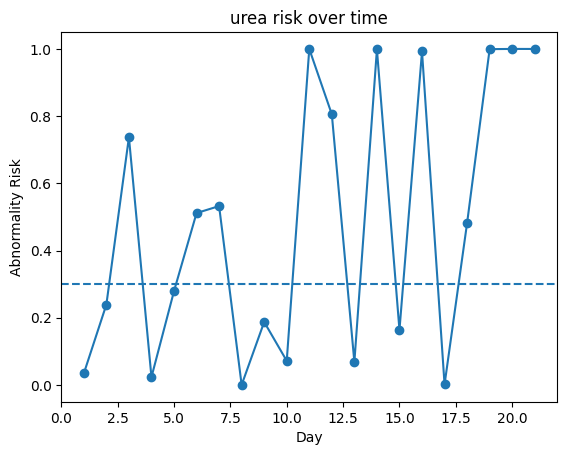

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(days, risk, marker="o")
plt.axhline(0.3, linestyle="--")
plt.xlabel("Day")
plt.ylabel("Abnormality Risk")
plt.title(f"{marker} risk over time")
plt.show()


In [16]:
T = 5  # days
threshold = 0.3

persistent = [
    all(risk[max(0, i-T+1):i+1] > threshold)
    for i in range(len(risk))
]


In [17]:
subject_id = "R_0"
markers = ["urea", "temperature", "spo2"]
baseline_days = 7


In [18]:
subject_id = "N_0"   # normal subject
subject_id = "R_1"   # another at-risk subject (if exists)


In [19]:
from scipy.stats import norm
import matplotlib.pyplot as plt

sub = df[df["subject"] == subject_id].sort_values("day")
days = sub["day"].values


In [21]:
print("Available markers:", df.columns.tolist())
print("Subjects in df:", df['subject'].unique())
print("Number of rows for subject", subject_id, ":", len(sub))
print("Values for", marker, ":", sub[marker].values)


Available markers: ['subject', 'day', 'urea']
Subjects in df: ['N_0' 'R_0']
Number of rows for subject R_1 : 0
Values for urea : []


In [22]:
import numpy as np
import pandas as pd

np.random.seed(42)

DAYS = 21
SUBJECTS = ["N_0", "R_0"]
MARKERS = ["urea", "temperature", "spo2"]

rows = []

for s in SUBJECTS:
    for d in range(1, DAYS+1):
        urea = 30 + np.random.normal(0, 2)
        temp = 36.5 + np.random.normal(0, 0.15)
        spo2 = 98 + np.random.normal(0, 0.5)

        # persistent drift for at-risk subject
        if s == "R_0" and d > 7:
            urea += 0.3 * (d - 7)
            temp += 0.1 * (d - 7)
            spo2 -= 0.2 * (d - 7)

        rows.append({
            "subject": s,
            "day": d,
            "urea": urea,
            "temperature": temp,
            "spo2": spo2
        })

df = pd.DataFrame(rows)
print(df.head())


  subject  day       urea  temperature       spo2
0     N_0    1  30.993428    36.479260  98.323844
1     N_0    2  33.046060    36.464877  97.882932
2     N_0    3  33.158426    36.615115  97.765263
3     N_0    4  31.085120    36.430487  97.767135
4     N_0    5  30.483925    36.213008  97.137541


In [23]:
subject_id = "R_0"
markers = ["temperature", "spo2"]
baseline_days = 7

sub = df[df["subject"] == subject_id].sort_values("day")
days = sub["day"].values


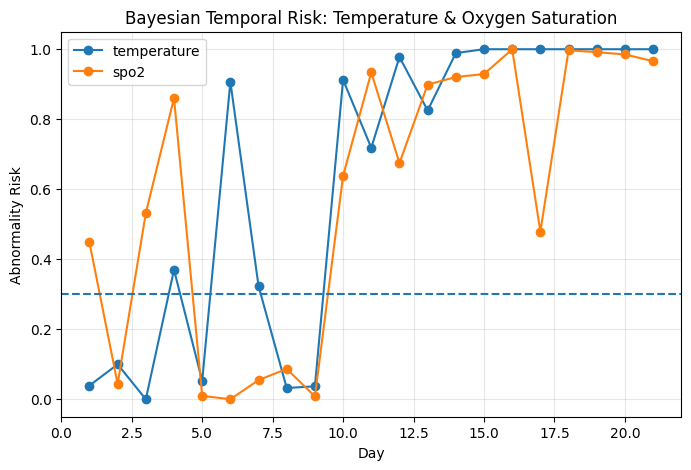

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# controls (only change these live)
subject_id = "R_0"
markers = ["temperature", "spo2"]
baseline_days = 7

# extract subject data
sub = df[df["subject"] == subject_id].sort_values("day")
days = sub["day"].values

plt.figure(figsize=(8, 5))

for marker in markers:
    values = sub[marker].values

    # baseline modeling
    baseline = values[:baseline_days]
    mu = baseline.mean()
    sigma = baseline.std() + 1e-3

    # Bayesian likelihood
    likelihood = norm.pdf(values, mu, sigma)

    # abnormality risk (0–1)
    risk = 1 - (likelihood / likelihood.max())

    plt.plot(days, risk, marker="o", label=marker)

# decision reference
plt.axhline(0.3, linestyle="--")

# labels & title
plt.xlabel("Day")
plt.ylabel("Abnormality Risk")
plt.title("Bayesian Temporal Risk: Temperature & Oxygen Saturation")
plt.legend()
plt.grid(alpha=0.3)

plt.show()
